In [ ]:
!pip install torchaudio
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import time
import random
import os
import copy
from typing import List, Dict, Tuple

import pandas as pd
import numpy as np
from scipy.io import wavfile

import torch
from torch import nn
from torch import optim
from torch.utils import data
from torch import Tensor

from torchvision import transforms

import torchaudio

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [ ]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
DATA_DIR = "drive/My Drive/Datasets/warblrb10k_public/"
CSV_PATH = os.path.join(DATA_DIR, "warblrb10k_public_metadata.csv")
WAV_DIR = os.path.join(DATA_DIR, "wav/")

In [ ]:
csv_df = pd.read_csv(CSV_PATH)
train_val_data, test_data = train_test_split(csv_df, train_size=0.8, 
                                             random_state=SEED)
train_data, val_data = train_test_split(train_val_data, train_size=0.75, 
                                        random_state=SEED)
train_bird, train_nobird = train_data['hasbird'].value_counts()
print("Train Class Imbalance:", train_bird / (train_bird + train_nobird))
val_bird, val_nobird = val_data['hasbird'].value_counts()
print("Valid Class Imbalance:", val_bird / (val_bird + val_nobird))
test_bird, test_nobird = test_data['hasbird'].value_counts()
print("Test Class Imbalance:", test_bird / (test_bird + test_nobird))

Train Class Imbalance: 0.7566666666666667
Valid Class Imbalance: 0.764375
Test Class Imbalance: 0.74375


In [ ]:
train_data

,itemid,hasbird
2767,4f5f3e27-9e23-460a-b871,1
1364,1cabcfa6-3cbd-4a75-86e5,1
1048,9eeb70e7-5931-4873-9b49,1
777,55b80302-a50e-43e7-bb62,1
3444,6bdb67b5-1983-4040-888b,1
...,...,...
7191,dfe7ba3b-58ca-42fe-9a9e,1
4416,f063a75c-29bb-4e5d-9917,1
6798,e20bc92e-0fed-40c8-9258,0
3465,f2e9bb5f-c8e5-468d-9a7e,1


In [ ]:
class SpecToTensor(torch.nn.Module):
    def __init__(self):
        super(SpecToTensor, self).__init__()

    def forward(self, waveform : np.ndarray) -> Tensor:
        return torch.from_numpy(waveform).float()
        
class SetWaveformLength(torch.nn.Module):
    def __init__(self, length : int = 1000):
        super(SetWaveformLength, self).__init__()
        self.length = length

    def forward(self, waveform : Tensor) -> Tensor:
        if waveform.shape[1] > self.length:
            return waveform.narrow(1, 0, self.length)
        else:
            while (waveform.shape[1] < self.length):
                waveform = torch.cat([waveform, 
                                      waveform.narrow(dim=1, start=0, 
                                                      length=min(self.length - waveform.shape[1], waveform.shape[1]))], dim=1)
            return waveform
            
class DetrendSpectrogram(torch.nn.Module):
    def __init__(self):
        super(DetrendSpectrogram, self).__init__()

    def forward(self, waveform : Tensor) -> Tensor:
        return waveform.sub(torch.mean(waveform, dim=1, keepdim=True))

class RandomCycle(torch.nn.Module):
    def __init__(self):
        super(RandomCycle, self).__init__();

    def forward(self, waveform : Tensor) -> Tensor:
        return torch.roll(input=waveform, 
                          shifts=np.random.randint(0, waveform.shape[1]),
                          dims=1)

class RandomPitchShift(torch.nn.Module):
    def __init__(self, bands=1):
        super(RandomPitchShift, self).__init__()
        self.bands = bands

    def forward(self, waveform : Tensor) -> Tensor:
        low = torch.roll(input=waveform, shifts=-self.bands, dims=0)
        high = torch.roll(input=waveform, shifts=self.bands, dims=0)
        alpha = np.random.rand()
        return torch.add(torch.mul(low, alpha), torch.mul(high, (1 - alpha)))

class Unsqueeze(torch.nn.Module):
    def __init__(self):
        super(Unsqueeze, self).__init__()
    
    def forward(self, waveform : Tensor) -> Tensor:
        return torch.unsqueeze(input=waveform, dim=0)

In [ ]:
def load_wav(audio_dir=None, file_id=None):
    fname = os.path.join(audio_dir, file_id + ".wav")
    return wavfile.read(filename=fname, mmap=True)

class WarblrDataset(data.Dataset):

    def __init__(self, root:str=None, csv_df:pd.DataFrame=None, 
                 audio_dir:str=None, transform:nn.Module=None):
        assert os.path.exists(os.path.abspath(root))
        assert os.path.exists(os.path.abspath(audio_dir))
        self._root = root
        self._audio_dir = audio_dir
        self._data = csv_df
        self._transform = transform

    def __len__(self) -> int:
        return len(self._data)
    
    def __getitem__(self, idx:int=0) -> Tuple[Tensor, int, int]:
        fileid, hasbird = self._data.iloc[idx,:]
        sr, waveform = load_wav(audio_dir=self._audio_dir, file_id=fileid)

        if self._transform:
            waveform = self._transform(waveform)
            
        return waveform, hasbird
        

In [ ]:
transform = transforms.Compose([
    SpecToTensor(),
    torchaudio.transforms.Resample(44100, 22050),
    torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_fft=1024, 
                                         hop_length=315, n_mels=80, f_min=50, 
                                         f_max=11000),
    torchaudio.transforms.AmplitudeToDB(stype='power'),
    SetWaveformLength(length=1000),
    DetrendSpectrogram(),
    RandomCycle(),
    RandomPitchShift(bands=1),
    Unsqueeze()])

In [ ]:
train_dataset = WarblrDataset(DATA_DIR, train_data, WAV_DIR, 
                              transform=transform)
val_dataset = WarblrDataset(DATA_DIR, val_data, WAV_DIR, 
                            transform=transform)
test_dataset = WarblrDataset(DATA_DIR, test_data, WAV_DIR, 
                             transform=transform)

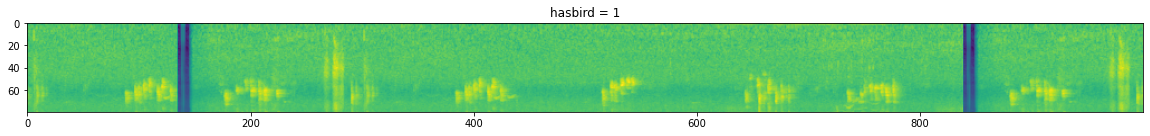

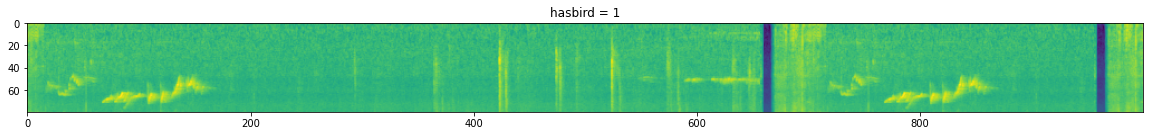

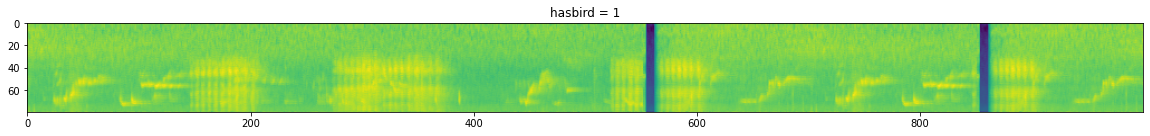

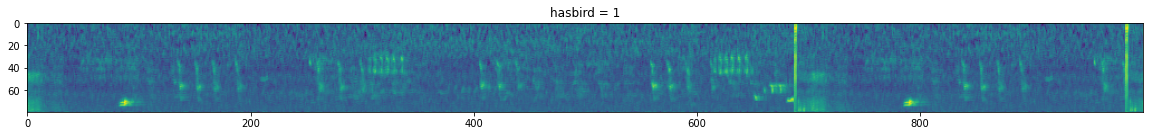

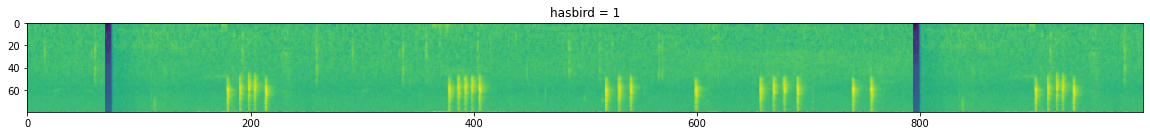

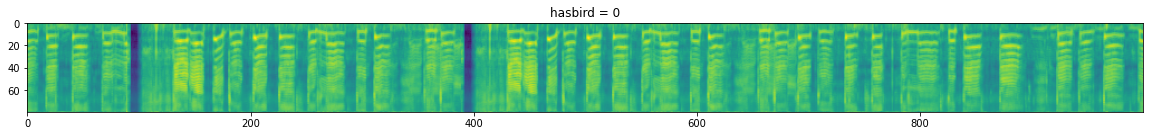

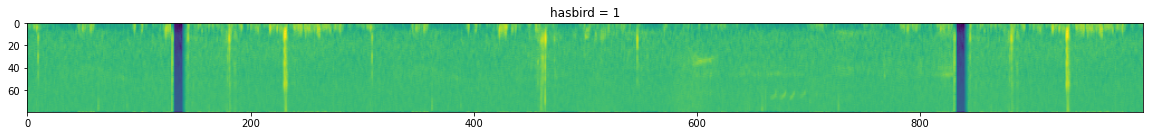

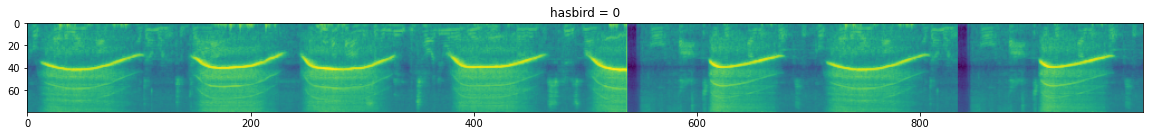

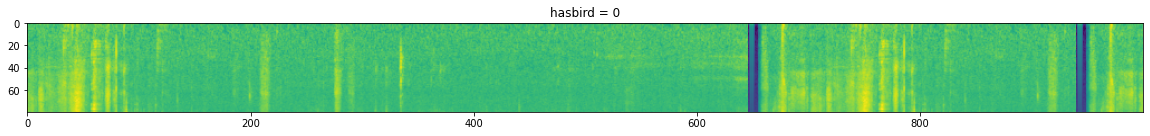

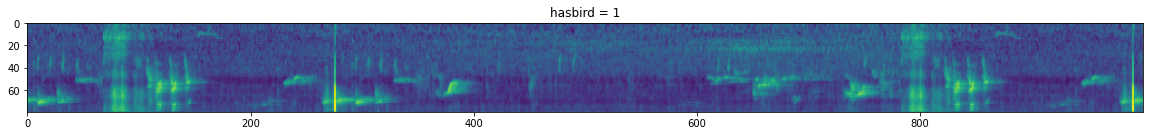

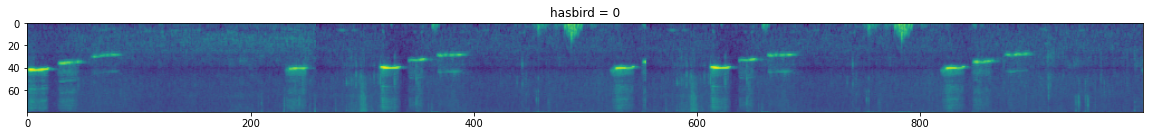

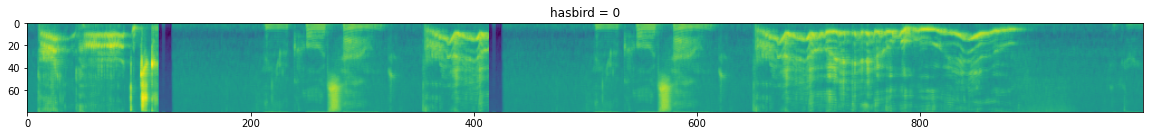

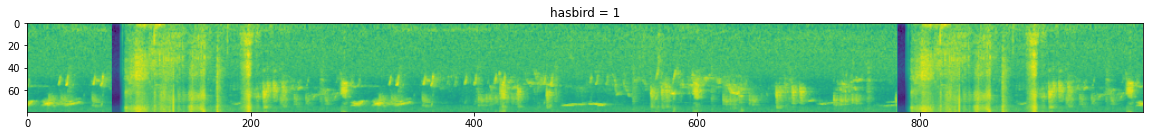

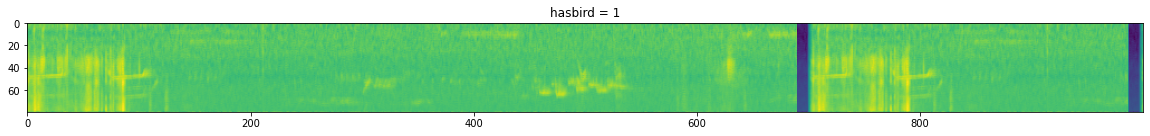

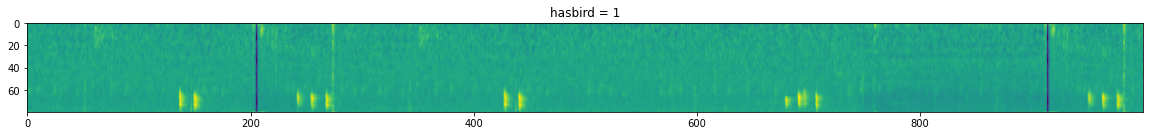

In [ ]:
for i in range(15):
    plt.figure(figsize = (20,3))
    waveform, label = train_dataset[i]
    plt.title("hasbird = " + str(label))
    plt.imshow(torch.squeeze(waveform, dim=0).numpy())

In [ ]:
class BaselineCNN(nn.Module):
    def __init__(self):

        super(BaselineCNN, self).__init__()

        self.norm = nn.BatchNorm2d(num_features=1)

        self.convolutional = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3)),
            nn.MaxPool2d(kernel_size=(3,3)),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3)),
            nn.MaxPool2d(kernel_size=(3,3)),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1,3)),
            nn.MaxPool2d(kernel_size=(1,3)),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1,3)),
            nn.MaxPool2d(kernel_size=(1,3)),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
        )

        self.linear = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(16 * 8 * 11, 256),      #(b,1408)->(b,256)
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 32),               #(b,256)->(b,32)  
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(32, 1),                 #(b,32)->(b,1)
            #nn.Sigmoid(), # BCEWithLogitsLoss
        )

    def forward(self, x):
        x = self.norm(x)                #(b,1,80,1000)->(b,1,80,1000)
        x = self.convolutional(x)       #(b,1,80,1000)->(b,16,8,11)
        flat = x.view(x.shape[0], -1)   #(b,16,8,11)  ->(b,1408)
        x = self.linear(flat)           #(b,1408)->(b,1)
        return x

In [ ]:
model = BaselineCNN()
def print_parameters(model):
    ''' Print the parameters of the model and the total number of parameters.

        Args:
            model (ConvNet): A simple convolutional neural network made with
                             Pytorch.
    '''
    print("Name", "# Params")
    sum = 0
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        print(name, param.numel())
        sum += param.numel()
    print("Total trainable parameters:", sum)

print(model)
print_parameters(model)

BaselineCNN(
  (norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convolutional): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Conv2d(16, 16, kernel_size=(1, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): Conv2d(16, 16, kernel_size=(1, 3), stride=(1, 1))
    (10): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (linear): Sequential(
    (0): D

In [ ]:
BATCH_SIZE = 64

optimizer = optim.Adam(model.parameters(), lr = 1e-3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pos_weights = torch.FloatTensor([train_nobird / train_bird])

loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

model = model.to(device)

loss_fn = loss_fn.to(device)

In [ ]:
train_iterator = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                                 shuffle=True)
val_iterator = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [ ]:
def calculate_accuracy(y_pred, y):
    '''
        Calculate the number of correct y predictions divided by the total
        number of predictions.

        Args:
            y_pred (torch.Tensor): A (Nx1) tensor, each row contains the 
                                   prediction of the model for a bird call.
            y (torch.Tensor): A (N,) tensor containing the true classes for each
                              call.
        Returns:
            acc (float): The proportion of correct predictions over total
                         predictions.
    '''
    s = nn.Sigmoid()
    preds = torch.round(s(y_pred))
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(y_pred, y):
    s = nn.Sigmoid()
    preds = torch.round(s(y_pred))
    preds = preds.cpu()
    y = y.cpu()
    tp, fn, fp, tn = confusion_matrix(y.view_as(preds), preds, labels=[1,0]).ravel()
    print(" ", "1", "0")
    print("1", tp, fn)
    print("0", fp, tn)

In [ ]:
def train(model, iterator, optimizer, loss_fn, device):
    '''
        Performs a single pass through the batch iterator, computes error,
        and updates model weights.

        Args:
            model (ConvNet): The CNN to perform weight updates on.
            iterator (DataLoader): Iterator that holds BATCH_SIZE img,class
                                   pairs at a time.
            optimizer (optim): Learning rate optimizer for individual parameters
            loss_fn: Computes loss and gradient descent for model parameters
            device: GPU or CPU
        Returns:
            Average loss and accuracy for all samples in batch.
    '''
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)

        y = y.float()
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = loss_fn(y_pred, y.view(-1,1))
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, loss_fn, device, report_confusion=False):
    '''
        Performs a single pass through the batch iterator, and computes loss
        and accuracy.

        Args:
            model (ConvNet): The CNN model to make predictions.
            iterator (DataLoader): Iterator that holds BATCH_SIZE img,class
                                   pairs at a time.
            loss_fn: Computes loss for predicted values and actual values
            device: GPU or CPU
        Returns:
            Average loss and accuracy for all samples in batch.
    '''

    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y = y.float()

            y_pred = model(x)

            loss = loss_fn(y_pred, y.view(-1,1))

            acc = calculate_accuracy(y_pred, y)

            if (report_confusion):
                print_confusion_matrix(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    '''
        Converts a given start time and end time into a duration in min:sec
        format.
    '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 150

best_loss = float('inf')
best_model = None

for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, loss_fn, device)
    valid_loss, valid_acc = evaluate(model, val_iterator, loss_fn, device)
        
    if valid_loss <= best_loss:
        best_loss = valid_loss
        best_model = copy.deepcopy(model.state_dict())

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print("Epoch:", epoch+1, "| Epoch Time:", epoch_mins, "m ", epoch_secs,"s")
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
torch.save(best_model, 'conv-model.pt')

Epoch: 1 | Epoch Time: 26 m  5 s
	Train Loss: 0.286 | Train Acc: 66.46%
	 Val. Loss: 0.235 |  Val. Acc: 78.12%
Epoch: 2 | Epoch Time: 3 m  9 s
	Train Loss: 0.235 | Train Acc: 76.85%
	 Val. Loss: 0.221 |  Val. Acc: 75.44%
Epoch: 3 | Epoch Time: 3 m  8 s
	Train Loss: 0.217 | Train Acc: 77.94%
	 Val. Loss: 0.212 |  Val. Acc: 76.06%
Epoch: 4 | Epoch Time: 3 m  5 s
	Train Loss: 0.202 | Train Acc: 79.62%
	 Val. Loss: 0.205 |  Val. Acc: 82.25%
Epoch: 5 | Epoch Time: 3 m  6 s
	Train Loss: 0.192 | Train Acc: 80.83%
	 Val. Loss: 0.197 |  Val. Acc: 78.50%
Epoch: 6 | Epoch Time: 3 m  6 s
	Train Loss: 0.186 | Train Acc: 81.52%
	 Val. Loss: 0.195 |  Val. Acc: 81.88%
Epoch: 7 | Epoch Time: 3 m  9 s
	Train Loss: 0.188 | Train Acc: 81.12%
	 Val. Loss: 0.205 |  Val. Acc: 84.25%
Epoch: 8 | Epoch Time: 3 m  5 s
	Train Loss: 0.185 | Train Acc: 82.50%
	 Val. Loss: 0.186 |  Val. Acc: 80.94%
Epoch: 9 | Epoch Time: 3 m  8 s
	Train Loss: 0.180 | Train Acc: 82.54%
	 Val. Loss: 0.190 |  Val. Acc: 81.69%
Epoch: 10

KeyboardInterrupt: ignored

In [ ]:
torch.save(best_model, 'conv-model.pt')

In [ ]:
model.load_state_dict(torch.load('conv-model.pt'))
model.to(device)

val_loss, val_acc = evaluate(model, val_iterator, loss_fn, device, True)

print(f'Validation Loss: {val_loss:.3f} | Validation Acc: {val_acc*100:.2f}%')

  1 0
1 44 7
0 3 10
  1 0
1 42 10
0 0 12
  1 0
1 43 8
0 2 11
  1 0
1 47 3
0 1 13
  1 0
1 42 7
0 0 15
  1 0
1 50 1
0 2 11
  1 0
1 31 11
0 2 20
  1 0
1 33 13
0 4 14
  1 0
1 48 2
0 0 14
  1 0
1 43 7
0 1 13
  1 0
1 43 11
0 1 9
  1 0
1 46 3
0 2 13
  1 0
1 43 8
0 1 12
  1 0
1 46 8
0 1 9
  1 0
1 40 8
0 4 12
  1 0
1 43 3
0 5 13
  1 0
1 45 5
0 5 9
  1 0
1 38 6
0 4 16
  1 0
1 39 13
0 3 9
  1 0
1 37 9
0 2 16
  1 0
1 41 6
0 1 16
  1 0
1 38 5
0 3 18
  1 0
1 43 8
0 3 10
  1 0
1 42 11
0 1 10
  1 0
1 39 4
0 4 17
Best Validation Loss: 0.175 | Validation Acc: 85.50%


In [ ]:
model.load_state_dict(torch.load('conv-model.pt'))
model.to(device)

test_loss, test_acc = evaluate(model, test_iterator, loss_fn, device, True)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

  1 0
1 39 5
0 2 18
  1 0
1 41 6
0 2 15
  1 0
1 39 8
0 2 15
  1 0
1 41 6
0 2 15
  1 0
1 46 4
0 1 13
  1 0
1 40 8
0 2 14
  1 0
1 33 12
0 1 18
  1 0
1 33 13
0 3 15
  1 0
1 33 9
0 2 20
  1 0
1 38 8
0 3 15
  1 0
1 42 6
0 1 15
  1 0
1 36 7
0 3 18
  1 0
1 42 8
0 2 12
  1 0
1 45 7
0 1 11
  1 0
1 40 7
0 1 16
  1 0
1 39 7
0 3 15
  1 0
1 40 9
0 0 15
  1 0
1 32 15
0 2 15
  1 0
1 42 5
0 1 16
  1 0
1 46 9
0 2 7
  1 0
1 34 11
0 1 18
  1 0
1 44 6
0 2 12
  1 0
1 38 12
0 1 13
  1 0
1 47 4
0 0 13
  1 0
1 34 14
0 3 13
Test Loss: 0.161 | Test Acc: 84.44%
